In [170]:
#17011505 안창언 중간 프로젝트 

import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

pd.set_option('display.max_rows', 10)

<Figure size 800x1000 with 0 Axes>

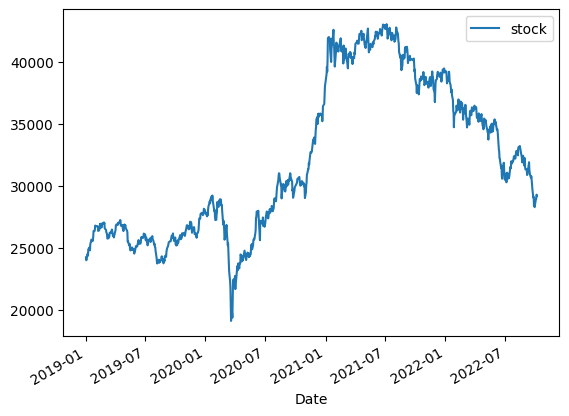

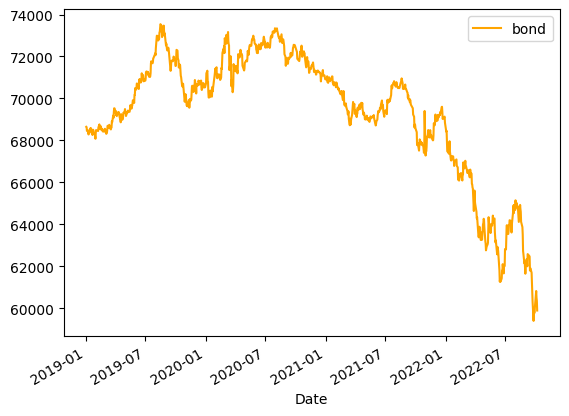

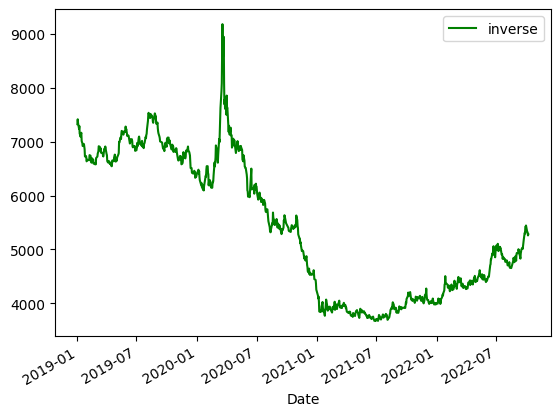

In [187]:
def getCloseDataPandas(ticker, start, end=None):
    return data.get_data_yahoo(ticker, start, end)["Close"]

def getCloseDataFdr(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)["Close"]

def getCloseData(ticker, start, end=None):
    try:
        return getCloseDataFdr(ticker, start, end)
    except:
        return getCloseDataPandas(ticker, start, end)

kodex200 = getCloseData("069500", "2019-01-01", "2022-10-10") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2019-01-01", "2022-10-10") # kodex 국고채 10년물 etf
kodexInverse = getCloseData("114800", "2019-01-01", "2022-10-10") # kodex 인버스 
#kodexSecurities = getClosedata("114260", "2019-01-01", "2022-10-10") # 국고채 
#dollar = getCloseData("261240", "2020-01-10", "2022-10-10") # 달러

plt.figure(figsize=(8, 10))
plt.subplots()
kodex200.plot(label="stock")
plt.legend()

plt.subplots()
kodex10Bond.plot(label="bond", color="orange")
plt.legend()

plt.subplots()
kodexInverse.plot(label="inverse", color="green")
plt.legend()

In [188]:
closeData = pd.concat([kodex200, kodex10Bond, kodexInverse], axis=1)
closeData.columns = ["stock", "bond", "inverse"]
closeData.dropna(inplace=True)

closeDataInverse = closeData.copy()
closeDataMomentum = closeData.copy().drop("inverse", axis=1)
closeDataBase = closeData.copy().drop("inverse", axis=1)
closeData

,stock,bond,inverse
Date,,,
2019-01-02,24225,68645,7325
2019-01-03,23990,68630,7415
2019-01-04,24173,68450,7345
2019-01-07,24516,68475,7240
2019-01-08,24360,68420,7290
...,...,...,...
2022-09-30,28275,60035,5445
2022-10-04,28960,60815,5315
2022-10-05,28965,60495,5315


In [189]:
def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data["year"] = data.index.year
    data["month"] = data.index.month

    #월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #분기말 리밸런싱 
    if period == "quarter":
        quarter = [3, 6, 9, 12]
        data = data.loc[data["month"].isin(quarter)]
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #연말 리밸런싱
    if period == "year":
        rebalancingDate = data.drop_duplicates(["year"], keep="last").index

    return rebalancingDate    

rebalDate = getRebalancingDate(closeData)
priceOnRebalDate = closeData.loc[rebalDate]
priceOnRebalDate

,stock,bond,inverse
Date,,,
2019-01-31,26764,68365,6645
2019-02-28,26562,68550,6695
2019-03-29,25981,69525,6870
2019-04-30,26711,69490,6670
2019-05-31,24714,70490,7235
...,...,...,...
2022-06-30,30808,62025,5025
2022-07-29,32385,64915,4770
2022-08-31,32230,61935,4790


In [200]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12, t="base"):
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평균 모멘텀 스코어 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n

    # 모멘텀 + 현금 + 인버스 자산군 고려 
    if t == "inverse":
        momentumSum = lambda momentum : momentum["stock"] + momentum["bond"]

        # momentum 평균이 0 초과 0.2 이하면 현금:인버스 = 3:2 투자 
        avgMomentumScore["cash"], avgMomentumScore["inverse"] = np.where(momentumSum(avgMomentumScore) <= 0.4 , 0.3, 0), np.where(momentumSum(avgMomentumScore) <= 0.4 , 0.2, 0)

        # momentum 평균이 0이면 현금:인버스 = 3:7 투자 
        avgMomentumScore["cash"], avgMomentumScore["inverse"] = np.where(momentumSum(avgMomentumScore) == 0, 0.3, avgMomentumScore["cash"]), np.where(momentumSum(avgMomentumScore) == 0, 0.7, avgMomentumScore["inverse"])

    # 현금 + 모멘텀 고려 
    elif t == "momentum":
        # 투자 비중이 모두 0인 구간에서는 현금 보유
        avgMomentumScore['cash'] = np.where(avgMomentumScore.sum(axis=1) == 0, 1, 0)

    # else 정적자산배분
        
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)

    # 투자비중, 평균 모멘텀 스코어 리턴
    return weight, avgMomentumScore



#pd.set_option('display.max_rows', None)
weight_momentum, avgMomentumScore_momentum = getWeightByAvgMomentumScore(closeDataMomentum, t="momentum")
print("momentum:\n\n ", weight_momentum, "\n\n", avgMomentumScore_momentum)

weight_inverse, avgMomentumScore_inverse = getWeightByAvgMomentumScore(closeDataInverse, t="inverse")
print("inverse: \n\n", weight_inverse, "\n\n", avgMomentumScore_inverse)
#pd.set_option('display.max_rows', 10)

momentum:

              stock  bond  cash
Date                         
2019-01-31   0.00  0.00   1.0
2019-02-28   0.00  1.00   0.0
2019-03-29   0.00  1.00   0.0
2019-04-30   0.50  0.50   0.0
2019-05-31   0.00  1.00   0.0
...           ...   ...   ...
2022-06-30   0.00  0.00   1.0
2022-07-29   0.25  0.75   0.0
2022-08-31   1.00  0.00   0.0
2022-09-30   0.00  0.00   1.0
2022-10-07   1.00  0.00   0.0

[46 rows x 3 columns] 

                stock      bond  cash
Date                                
2019-01-31  0.000000  0.000000     1
2019-02-28  0.000000  0.083333     0
2019-03-29  0.000000  0.166667     0
2019-04-30  0.166667  0.166667     0
2019-05-31  0.000000  0.333333     0
...              ...       ...   ...
2022-06-30  0.000000  0.000000     1
2022-07-29  0.083333  0.250000     0
2022-08-31  0.083333  0.000000     0
2022-09-30  0.000000  0.000000     1
2022-10-07  0.083333  0.000000     0

[46 rows x 3 columns]
inverse: 

                stock      bond   inverse      cash
Date

In [201]:
# base
def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getRebalancingPortfolio(closeDataSet, period="month", weightDf=None, rebalDate=None):
    #자산별 비중, 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period)
        
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)],
                                index=rebalancingDate,
                                columns=closeDataSet.columns)

    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        if rebalDate is None:
            rebalancingDate = getRebalancingDate(closeDataSet, period=period)
        else:
            rebalancingDate = rebalDate

    portfolio = pd.DataFrame()

    totalAsset = 1
    start = rebalancingDate[0]
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end]
        cumRet = getCumulativeReturn(priceData)
        weightCumRet = weight * cumRet
        netCumRet = totalAsset * weightCumRet

        #print(f"cumret:\n{cumRet}\n\nweight:\n{weight}\n\nweightcumret:\n{weightCumRet}\n\nnetcumret:\n{netCumRet}")
        
        start = end
        totalAsset = netCumRet.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumRet])

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep="last")]
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1))

    return portfolioDayReturn, portfolioCumulativeReturn
    
def getEval(cumRet):
    cagr = cumRet.iloc[-1] ** (252/len(cumRet))

    dd = (cumRet.cummax() - cumRet) / cumRet.cummax() * 100
    mdd = dd.max()
       
    print(f"return: {cumRet.iloc[-1]} \n cagr: {cagr} \n mdd: {mdd}\n\n")
    
    return cagr, dd, mdd



In [202]:
# base
dayRetBase, cumRetBase = getRebalancingPortfolio(closeDataSet=closeDataBase.truncate(before="2020-01-02"), weightDf=None)
print(f"Base 최종수익률: {cumRetBase.iloc[-1]}")
base_cagr, base_dd, base_mdd = getEval(cumRetBase)

# 12 month average momentum
closeDataMomentum["cash"] = 1
dayRetMomentum, cumRetMomentum = getRebalancingPortfolio(closeDataSet=closeDataMomentum.truncate(before="2020-01-02"), weightDf=weight_momentum.truncate(before="2020-01-02"))
print(f"12개월 평균 모멘텀 스코어 최종수익률: {cumRetMomentum.iloc[-1]}")
momentum_cagr, momentum_dd, momentum_mdd = getEval(cumRetMomentum)

# 12 month average momentum
closeDataInverse["cash"] = 1
dayRetInverse, cumRetInverse = getRebalancingPortfolio(closeDataSet=closeDataInverse.truncate(before="2020-01-02"), weightDf=weight_inverse.truncate(before="2020-01-02"))
print(f"인버스 자산군 + 12개월 평균 모멘텀 스코어 최종수익률: {cumRetInverse.iloc[-1]}")
inverse_cagr, inverse_dd, inverse_mdd = getEval(cumRetInverse)

Base 최종수익률: 0.96211262315037
return: 0.96211262315037 
 cagr: 0.9854702175887616 
 mdd: 24.810728024189835


12개월 평균 모멘텀 스코어 최종수익률: 0.9695202631229443
return: 0.9695202631229443 
 cagr: 0.9883386266463468 
 mdd: 30.154562865970004


인버스 자산군 + 12개월 평균 모멘텀 스코어 최종수익률: 1.3007567261046684
return: 1.3007567261046684 
 cagr: 1.1047761856592135 
 mdd: 12.823199278157482




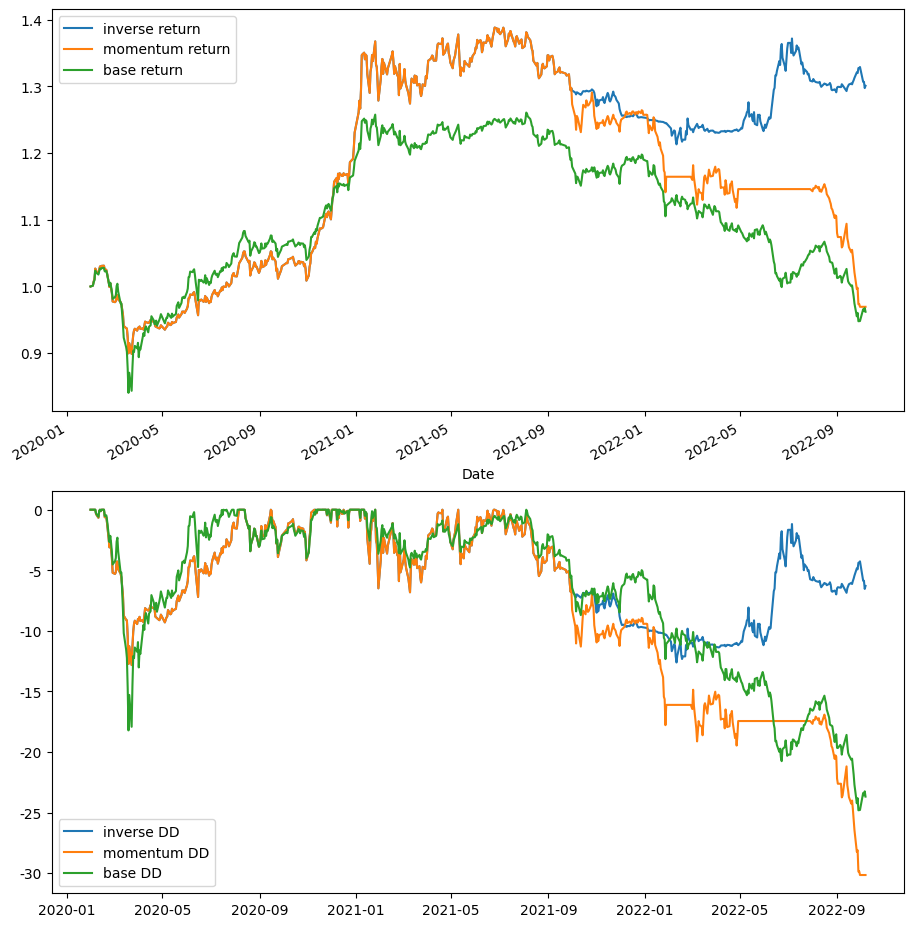

In [203]:
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(11,13))

# 수익곡선
plt.subplot(2,1,1)
cumRetInverse.plot(label="inverse return")
cumRetMomentum.plot(label="momentum return")
cumRetBase.plot(label="base return")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-inverse_dd, label="inverse DD")
plt.plot(-momentum_dd, label="momentum DD")
plt.plot(-base_dd, label="base DD")
plt.legend()

plt.show()
